# Dog Breed Identification : avant de commencer

L'objectif de ce projet est de créer un modèle de réseau de neurones pour prédir la race d'un chien à partir de sa photo.   
L'apprentissage de ce modèle sera fait en utilsant les images du dossier `train`.   
Ce dossier contient un sous-ensemble strictement canin d'ImageNet des 120 catégories de chien.   
Les données et plus d'information sur https://www.kaggle.com/c/dog-breed-identification .
    
Dans ce cadre nous allons créer les 4 modèles suivants dans 4 feuilles Notebook (une 5éme pour l'application sur les données test de Kaggle) :   

* Modèle AlexNet (en utilisant une fonction native pour la récupération des images).
* Modèle Xception (en utilisant une fonction native pour la récupération des images).
* Modèle AlexNet (avec ImageDataGeneration).
* Modèle Xception (avec ImageDataGeneration).



# Module data_prep

Ce module a été créé pour récupérer les données de ce projet et les mettre dans le format souhaité.   
Il contient la fonction `load_data` qui est la suivante: 

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
from random import shuffle
import os

def load_data(df_train,PATH,IMG_SIZE,convert=False,flip = False):
  train_dir = os.path.join(PATH, 'train')

  data = []
  
  nb_ax = 1 if convert else 3

  for img in os.listdir(train_dir):
    label = df_train.loc[img][1]
    path = os.path.join(train_dir, img)
    img = Image.open(path)
    if convert:
      img = img.convert('L')
    img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
    data.append([np.array(img), label])

    if flip :
      # Basic Data Augmentation - Horizontal Flipping
      flip_img = Image.open(path)
      if convert:
        flip_img = flip_img.convert('L')
      flip_img = flip_img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
      flip_img = np.array(flip_img)
      flip_img = np.fliplr(flip_img)
      data.append([flip_img, label])

  shuffle(data)

  dataX = np.array([i[0] for i in data]).reshape(-1, IMG_SIZE, IMG_SIZE,nb_ax)
  dataY = np.array([i[1] for i in data])


  def shuffle_home(matrix, target, test_proportion):
    ratio = int(matrix.shape[0]/test_proportion)
    X_train = matrix[:ratio]
    X_test =  matrix[ratio:]
    Y_train = target[:ratio]
    Y_test =  target[ratio:]
    return X_train, X_test, Y_train, Y_test

  return shuffle_home(dataX, dataY, 1.5)

Ses paramétres sont :
* df_train : qui le fichier csv qui contient les id et les modalités des images qui seront utilisés pour l'apprentissage des modèles.   
* PATH : le chemin du répertoire contenant les images qui vont servir à l'apprentissage.   
* convert : les images des données seront convertir de `RGB` au `gray` s'il est VRAI.   
* flip : augmente la taille du jeu de données en ajoutant des nouveux images avec un enversement horizontal des anciens s'il est VRAI.   

# Modèle de base

## Préparation de l'environnement du travail

### Importation des packages

In [19]:
from data_prep import load_data
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
import pickle

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


Pour ce premier modèle nous utilisrons le CPU pour créer et entraîner le modèle !

### Dézipper le fichier de données

In [4]:
zip_ref = zipfile.ZipFile("dog-breed-identification.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

### Récupération des données

Les données sont en deux parties: 
1. Le ficher `labels.csv` qui contient les `id` des images (le nom de fichier image sans extension) liés à leur modalité `breed`.
2. Le dossier `train` avec les images en format jpg.

Commençant par ajouter l'extension `.jpg` aux id des images dans `labels.csv` pour faciliter les tâches par la suite.

In [5]:
def append_ext(fn):
  return fn+".jpg"

In [6]:
df_train = pd.read_csv("/tmp/labels.csv")
df_train['id'] = df_train['id'].apply(append_ext)
df_train = df_train.set_index('id')
labelNames = df_train["breed"].unique()
labelNames.shape

(120,)

Nous avons 120 types de chiens (120 modalités), et 10222 images dans le dossier train.

In [7]:
df_train.head()

breed
id                                                    
000bec180eb18c7604dcecc8fe0dba07.jpg       boston_bull
001513dfcb2ffafc82cccf4d8bbaba97.jpg             dingo
001cdf01b096e06d78e9e5112d419397.jpg          pekinese
00214f311d5d2247d5dfe4fe24b2303d.jpg          bluetick
0021f9ceb3235effd7fcde7f7538ed62.jpg  golden_retriever

Ensuite, nous allons encoder ces modalités grâce à `LabelEncoder` pour avoir des nombres au lieu des chaînes de caractères :

In [8]:
le = LabelEncoder()
le.fit(df_train['breed'])
df_train['y'] = le.transform(df_train['breed'])

## Création du modèle (train/test)

Avant de passer à l'entraînement, nous allons formatez les images en `tensors` à virgule flottante en les prétraitant de la manière suivante :

1.   Lire les images du disque.
2.   Décoder le contenu de ces images et le convertir au format de grille approprié selon leur contenu RGB.
3.   Convertir les en `tensors` à virgule flottante des valeurs entre 0 et 255 à des valeurs comprises entre 0 et 1.
4.   Redimensionnez les images.

Le module `data_prep` créé dans le cadre de ce projet, contient la fonction pour `load_data` qui permet d'avoir les images en format souhaité.

In [9]:
PATH = "/tmp/"
IMG_SIZE = 71
trainX,testX,trainY,testY = load_data(df_train,PATH,IMG_SIZE=IMG_SIZE,convert=True)

La taille des images est fixé à  et le paramètre `convert` de `load_data` permet de convertir les images en couleur RGB en Gray.

In [10]:
trainX.shape

(6814, 71, 71, 1)

In [11]:
testX.shape

(3408, 71, 71, 1)

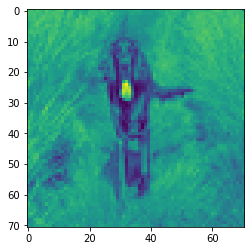

In [12]:
plt.imshow(np.squeeze(trainX,axis=3)[5121,:,:])

In [13]:
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

### Hyper-paramètres

Fixant quelques hyper-paramètres et les variables qui seront utilisés pour l'entraînement :

In [14]:
learning_rate = 0.01
m = trainX.shape[0]
input_shape = (IMG_SIZE, IMG_SIZE, 1)

# Gradient descent
opt = SGD(lr=learning_rate)

In [26]:
model = Sequential([
                    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE ,1)),
                    MaxPooling2D(),
                    Conv2D(32, 3, padding='same', activation='relu'),
                    MaxPooling2D(),
                    Conv2D(64, 3, padding='same', activation='relu'),
                    MaxPooling2D(),
                    Dropout(0.25),
                    Flatten(),
                    Dense(512, activation='relu'),
                    Dropout(0.5),
                    Dense(120, activation='softmax')
])

In [27]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [28]:
history = model.fit(trainX, trainY,
                   validation_data=(testX, testY))

Train on 6814 samples, validate on 3408 samples
6814/6814 [==============================] - 17s 2ms/sample - loss: 4.7877 - accuracy: 0.0076 - val_loss: 4.7868 - val_accuracy: 0.0103


In [29]:
model.save("models/Simple/modelSimple.h5")
with open('models/Simple/modelSimpleHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)